In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import pandas as pd
from fastai.text import *

In [0]:
from google.colab import drive
drive.mount('/content/drive/')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
path = '/content/drive/My Drive/Ai Saturdays/'

In [0]:
df = pd.read_csv(path+"ds_tweets.csv")
df.head()

,text,clasificacion
0,No puedo con las mujeres que no se depilan las...,M
1,"""Quitatelo pero mañana me compras la pastilla""...",M
2,Doña Pamela Martínez ya debe tener la lengua c...,M
3,Me molesta mucho esa idea de que las mujeres m...,M
4,@amor_y_rap_ Un man que le dijo a una señora q...,M


In [0]:
df.shape

(2194, 2)

In [0]:
print(df.columns)
print(df.shape)
print(df.text.count())

Index(['text', 'clasificacion'], dtype='object')
(2194, 2)
2194


# Cleaning

In [0]:
df.text.values

array(['No puedo con las mujeres que no se depilan las cejas.... y me es inevitable pensar que si así tienen las cejas ¿cómo tendrán aquello? 🙈🙈🤣🤣',
       '"Quitatelo pero mañana me compras la pastilla"  —Exclamó la princesa.',
       'Doña Pamela Martínez ya debe tener la lengua con ampollas de tanto hablar. https://t.co/GwhKZoKjF1',
       'Me molesta mucho esa idea de que las mujeres madres tienen casi que marginarse de espacios PÚBLICOS porque tienen hijos que, adivinen qué, lloran. Claro, el llanto es molesto. Pero qué arribismo tan mierda. "Si su hijo llora quédense en casa". No tienen derecho o qué? Fastidiosos',
       ..., 'Capturan a segundo implicado en el feminicidio de Alicia Diaz. ',
       'El productor ha sido acusado por unas 70 mujeres de abuso sexual en distinto grado.',
       'Agresor sexual de niña de un año es buscado por las autoridades. ',
       'El presunto delito de violación se habría producido de forma grupal.'], dtype=object)

In [0]:
df["text"] = df["text"].str.replace(r"(@)[A-Za-z0-9_]+", "")
df["text"] = df["text"].str.replace(r':', '')
df["text"] = df["text"].str.replace(r'‚Ä¶', '')
df["text"] = df["text"].str.replace("\"", "")
df["text"] = df["text"].str.replace(r'^https?:\/\/.*[\r\n]*', '')
df["text"] = df["text"].str.replace(r'http\S+', '')
df["text"] = df["text"].dropna()
df = df[df["text"]!=""]
df = df[df["clasificacion"]!=""]

df = df[~df["clasificacion"].isna()]


In [0]:
 df.text.values

array(['No puedo con las mujeres que no se depilan las cejas.... y me es inevitable pensar que si así tienen las cejas ¿cómo tendrán aquello? 🙈🙈🤣🤣',
       'Quitatelo pero mañana me compras la pastilla  —Exclamó la princesa.',
       'Doña Pamela Martínez ya debe tener la lengua con ampollas de tanto hablar. ',
       'Me molesta mucho esa idea de que las mujeres madres tienen casi que marginarse de espacios PÚBLICOS porque tienen hijos que, adivinen qué, lloran. Claro, el llanto es molesto. Pero qué arribismo tan mierda. Si su hijo llora quédense en casa. No tienen derecho o qué? Fastidiosos',
       ..., 'Capturan a segundo implicado en el feminicidio de Alicia Diaz. ',
       'El productor ha sido acusado por unas 70 mujeres de abuso sexual en distinto grado.',
       'Agresor sexual de niña de un año es buscado por las autoridades. ',
       'El presunto delito de violación se habría producido de forma grupal.'], dtype=object)

# Preprocessing

In [0]:
from fastai.text import *

In [0]:
df.to_csv(path+"ForModel.csv", encoding ='utf-8')
df = pd.read_csv(path+"ForModel.csv")

In [0]:
data_lm = (TextList.from_csv(path, path+"ForModel.csv", cols='text')
           #Inputs: all the text files in path
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch())
data_lm.save('data_lm.pkl')

In [0]:
data_lm = load_data(path, 'data_lm.pkl')

In [0]:
data_lm.show_batch()

idx,text
0,"xxmaj me xxunk mucho esa idea de que las mujeres madres tienen casi que xxunk de xxunk xxup públicos porque tienen hijos que , xxunk qué , xxunk . xxmaj claro , el xxunk es xxunk . xxmaj pero qué xxunk tan mierda . xxmaj si su hijo llora xxunk en casa . xxmaj no tienen derecho o qué ? xxmaj xxunk xxbos xxmaj un man que le dijo a"
1,"xxbos xxmaj si tanto le importa la democracia xxup no siga xxunk de la xxunk ! ! # xxunk xxbos xxmaj xxunk xxbos xxmaj para la gente que no sabe xxunk xxunk . xxbos xxmaj xxunk xxbos xxmaj te xxunk xxunk el xxunk y el xxunk con la xxunk xxunk xxbos xxmaj este es el xxunk del xxunk , con eso quiere xxunk sus xxunk . xxbos xxmaj que xxunk"
2,"ley fueron xxunk por xxunk , 6 por el xxmaj xxunk y 3 por la xxmaj fiscalía xxmaj general , entre mayo de 2018 y mismo mes de 2019 . xxbos xxup xxunk cuando a las xxunk les gusta el sexo duro o fuerte por xxunk así les hacen eso o en otras xxunk es por puro gusto personal se llama xxunk xxunk es parte de xxup xxunk xxbos 🏆"
3,que no quiera ver . xxmaj total xxunk de final . xxbos xxmaj la xxunk parte es el # xxunk 🤣 🤣 🤣 xxbos xxmaj gracias a ti xxmaj xxunk por tanta xxunk que nos xxunk a los ecuatorianos xxbos la veré hoy ! xxmaj pilas para xxunk después xxbos xxmaj su xxunk xxmaj xxunk que tiene xxunk con otro equipo .. xxmaj xxunk que es un jugador mal xxunk
4,"ministra de la muerte xxunk xxunk # xxunk xxmaj xxunk xxmaj xxunk vía xxbos xxmaj alguna tienda xxunk xxunk de xxunk de xxmaj xxunk a buen xxunk ? xxbos xxmaj mamá no es que no xxunk en ti , pero tú ya tienes suficiente con tus problemas .. xxunk me gusto ser una xxunk . xxbos xxmaj que xxunk ! ! ! xxbos xxmaj como xxunk de la xxunk de"


In [0]:
data_lm.vocab.itos[:20]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '.',
 'de',
 'la',
 ',',
 'que',
 'a',
 'y',
 'en',
 'el',
 'no',
 'las']

# Language model fine-tuning

In [0]:
weights_pretrained = path+'converted_model'
itos_pretrained = path+'itos'
pretained_data = (weights_pretrained, itos_pretrained)
learn = language_model_learner(data_lm, AWD_LSTM, pretrained_fnames=pretained_data, drop_mult=0.8)

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


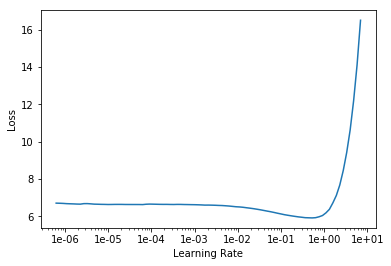

In [0]:
learn.recorder.plot(skip_end=1)

In [0]:
learn.fit_one_cycle(1, 1e-001, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.608965,4.277326,0.258371,00:01


In [0]:
learn.save('fit_head')

In [0]:
learn.load('fit_head');

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(30, 1e-003, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.595298,4.243691,0.257589,00:02
1,4.573003,4.181278,0.279129,00:02
2,4.537681,4.123278,0.288170,00:02
3,4.492321,4.055836,0.295201,00:02
4,4.445423,3.989018,0.300446,00:02
5,4.392853,3.919620,0.307254,00:02
6,4.334167,3.855956,0.315737,00:02
7,4.275239,3.797847,0.312277,00:02
8,4.212018,3.755106,0.318527,00:02
9,4.146560,3.709920,0.321987,00:02


In [0]:
learn.save('fine_tuned')

In [0]:
learn.load('fine_tuned');

In [0]:
TEXT = "Que haremos "
N_WORDS = 15
N_SENTENCES = 5

In [0]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

Que haremos  por las mujeres son están de las derechos y las derechos de los tenemos y
Que haremos  que lo que quito , ni que no se va a su mujer en
Que haremos  la una mujer que se les gusta que no te quiero . xxbos Que
Que haremos  , el hombre que me ha me brasil de me quiero que llamar gente a
Que haremos  de la lucha del mundo en Argentina Castellón . xxbos No es


In [0]:
learn.save_encoder('fine_tuned_enc')

# Classifier

In [0]:
data_clas = (TextList.from_csv(path, path+"ForModel.csv", cols='text', vocab=data_lm.vocab)
             .split_by_rand_pct()
             .label_from_df(cols='clasificacion')
             .databunch())

In [0]:
data_clas.save('data_clas.pkl')

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.6)
learn.load_encoder('fine_tuned_enc')

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


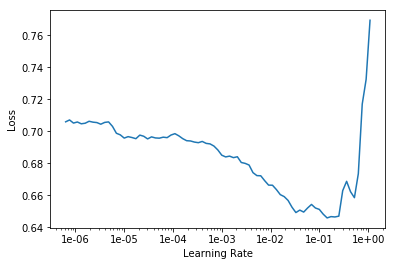

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(8, 1e-02, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.620373,0.588684,0.739726,00:01
1,0.580196,0.499895,0.744292,00:01
2,0.556765,0.471039,0.778539,00:01
3,0.532460,0.488642,0.767123,00:01
4,0.518779,0.476606,0.762557,00:01
5,0.505894,0.459834,0.760274,00:01
6,0.487000,0.460401,0.762557,00:01
7,0.475590,0.456771,0.753425,00:01


In [0]:
learn.save('first')

In [0]:
learn.load('first');

In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(4, slice(1e-02/(2.6**4),1e-02), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.467276,0.450375,0.771689,00:01
1,0.491115,0.455453,0.780822,00:01
2,0.461827,0.446227,0.801370,00:01
3,0.433659,0.429613,0.801370,00:01


In [0]:
learn.save('second')

In [0]:
learn.load('second');

In [0]:
learn.save('lastModel_v5second')

In [0]:
learn.save_encoder('lastModel_enc_v5second')

# Test

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

from fastai.text import *
path = '/content/drive/My Drive/Ai Saturdays/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
data_clas = load_data(path, 'data_clas.pkl')
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.6)
learn.load('lastModel_v5second')
learn.load_encoder('lastModel_enc_v5second')


In [0]:
learn.predict("Las mujeres a la cocina")

(Category M, tensor(0), tensor([0.7128, 0.2872]))

In [0]:
learn.predict("Las mujeres no saben de futbol")

(Category M, tensor(0), tensor([0.5707, 0.4293]))

In [0]:
learn.predict("La mujer debe tener voz y voto")

(Category P, tensor(1), tensor([0.3546, 0.6454]))

In [0]:
learn.predict("Todas las personas deberíamos tener los mismos derechos")

(Category P, tensor(1), tensor([0.0382, 0.9618]))

In [0]:
learn.predict("Un man que le dijo a una señora que estaba con su hija no la debería traer acá porque llora mucho, ¿usted no entiende que a estos conciertos no deben ir niños?al escuchar eso entré en ira y lo perseguí al baño y cuando lo encontré le dije vos sos un hijo de puta machista.")

(Category M, tensor(0), tensor([0.9625, 0.0375]))

In [0]:
learn.predict("las mujeres deben pensar antes de abrir las piernas")

(Category M, tensor(0), tensor([0.6534, 0.3466]))

In [0]:
learn.predict("mujer tenía que ser")

(Category M, tensor(0), tensor([0.5596, 0.4404]))